In [6]:
from pathlib import Path

import polars as pl

from trade_analysis.ingress import load_trade_csv_v2
from trade_analysis.processing import compute_shares, compute_hhi, compute_product_weights
from trade_analysis.charts.pie import plot_pie
from trade_analysis.charts.share import plot_share_over_time
from trade_analysis.charts.bar import plot_bar
from trade_analysis.charts.hhi import plot_hhi_over_time
from trade_analysis.hypothesis_testing import screen_share_breaks, screen_hhi_breaks, compare_breakpoints
from trade_analysis.charts.trends import plot_segmented_trend, plot_hypothesis_summary

In [7]:
df = load_trade_csv_v2(Path("data/hs30.csv"))
result = compute_shares(df)
hhi = compute_hhi(result)
print(result)
print(hhi)

shape: (9_296, 12)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ partner_c ┆ partner_n ┆ product_c ┆ product_n ┆ … ┆ yoy_chang ┆ ma_3y     ┆ is_signif ┆ was_sign │
│ ode       ┆ ame       ┆ ode       ┆ ame       ┆   ┆ e_percent ┆ ---       ┆ icant     ┆ ificant  │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ f64       ┆ ---       ┆ ---      │
│ str       ┆ str       ┆ i64       ┆ str       ┆   ┆ f64       ┆           ┆ bool      ┆ bool     │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ AD        ┆ Andorra   ┆ 30        ┆ PHARMACEU ┆ … ┆ null      ┆ null      ┆ false     ┆ null     │
│           ┆           ┆           ┆ TICAL     ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆           ┆ PRODUCTS  ┆   ┆           ┆           ┆           ┆          │
│ AD        ┆ Andorra   ┆ 30        ┆ PHARMACEU ┆ … ┆ 36.307927 ┆ 217226

In [8]:
weights = compute_product_weights(result, baseline_end=2019)
print(weights)

min_weight = 2.5
relevant_codes = weights.filter(pl.col("weight_pct") >= min_weight)["product_code"].to_list()
result_f = result.filter(pl.col("product_code").is_in(relevant_codes))
hhi_f = hhi.filter(pl.col("product_code").is_in(relevant_codes))
print(f"Subchapters >= {min_weight}% weight: {len(relevant_codes)} of {weights.height}")

shape: (6, 4)
┌──────────────┬─────────────────────────────────┬─────────────┬────────────┐
│ product_code ┆ product_name                    ┆ total_value ┆ weight_pct │
│ ---          ┆ ---                             ┆ ---         ┆ ---        │
│ i64          ┆ str                             ┆ f64         ┆ f64        │
╞══════════════╪═════════════════════════════════╪═════════════╪════════════╡
│ 3004         ┆ Medicaments consisting of mixe… ┆ 2.2896e11   ┆ 53.33494   │
│ 3002         ┆ Human blood; animal blood prep… ┆ 1.5492e11   ┆ 36.087864  │
│ 3003         ┆ Medicaments consisting of two … ┆ 2.4268e10   ┆ 5.653018   │
│ 3006         ┆ Pharmaceutical preparations an… ┆ 8.1956e9    ┆ 1.909125   │
│ 3001         ┆ Dried glands and other organs … ┆ 6.5677e9    ┆ 1.529917   │
│ 3005         ┆ Wadding, gauze, bandages and t… ┆ 6.3755e9    ┆ 1.485136   │
└──────────────┴─────────────────────────────────┴─────────────┴────────────┘
Subchapters >= 2.5% weight: 3 of 6


In [9]:
product_codes = result["product_code"].unique().sort()
analysis_years = result["time_period"].unique().sort()

print("Product codes:", product_codes.to_list())
print("Years:", analysis_years.to_list())

Product codes: [30, 3001, 3002, 3003, 3004, 3005, 3006]
Years: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [10]:
# Line chart: China's share over time for each product
#for code in product_codes:
    #plot_share_over_time(result, code, partner_code="CN")

In [12]:
# Pie charts: partner breakdown for a specific product and year
#year in analysis_years:
    #plot_pie(result, 3001, year, hhi_df=hhi)

In [13]:
# Bar charts: partner trade values for a specific product and year
#for year in analysis_years:
    #plot_bar(result, 3001, year, hhi_df=hhi)

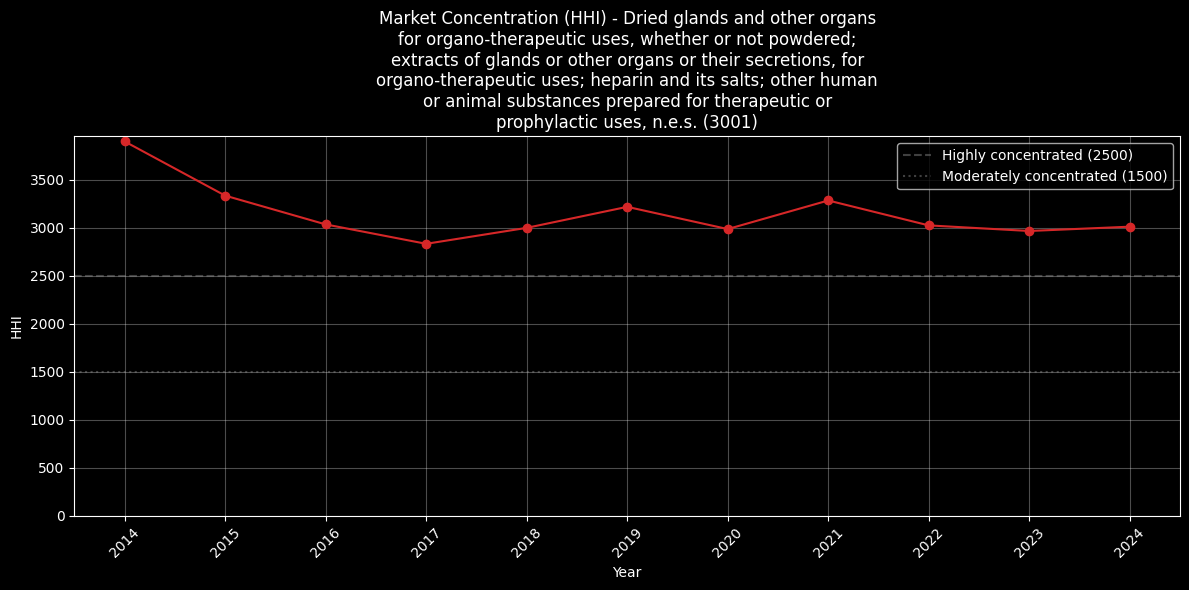

In [14]:
# HHI concentration over time for each product
code = 3001
name = result.filter(pl.col("product_code") == code)["product_name"][0]
plot_hhi_over_time(hhi, code, product_name=name)

## H1: China's import share — slope break screening at 2020

In [15]:
h1_2020 = screen_share_breaks(result_f, partner_code="CN", cutoff_year=2020, threshold=0.5)
print(h1_2020)

shape: (3, 10)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ product_c ┆ product_n ┆ slope_bef ┆ slope_aft ┆ … ┆ level_aft ┆ level_cha ┆ direction ┆ is_meani │
│ ode       ┆ ame       ┆ ore       ┆ er        ┆   ┆ er        ┆ nge       ┆ ---       ┆ ngful    │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ str       ┆ ---      │
│ i64       ┆ str       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆           ┆ bool     │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 3002      ┆ Human     ┆ 0.012     ┆ -1.1441   ┆ … ┆ 5.83      ┆ 5.68      ┆ declining ┆ true     │
│           ┆ blood;    ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ animal    ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ blood     ┆           ┆           ┆   ┆           ┆           

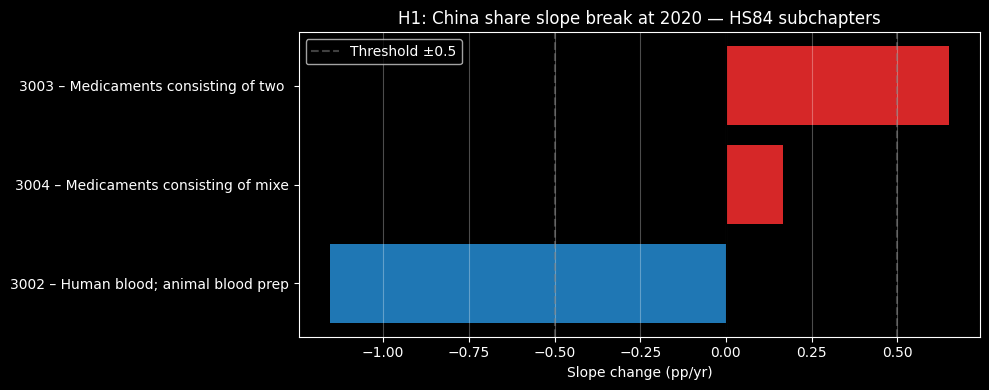

In [16]:
plot_hypothesis_summary(
    h1_2020,
    metric_label="Slope change (pp/yr)",
    title="H1: China share slope break at 2020 — HS84 subchapters",
    threshold=0.5,
)

## H2: HHI concentration — slope break screening at 2020

In [17]:
h2_2020 = screen_hhi_breaks(hhi_f, cutoff_year=2020, threshold=50)
print(h2_2020)

shape: (3, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ product_c ┆ slope_bef ┆ slope_aft ┆ slope_cha ┆ … ┆ level_aft ┆ level_cha ┆ direction ┆ is_meani │
│ ode       ┆ ore       ┆ er        ┆ nge       ┆   ┆ er        ┆ nge       ┆ ---       ┆ ngful    │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ str       ┆ ---      │
│ i64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆           ┆ bool     │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 3003      ┆ 56.66     ┆ -68.7     ┆ -125.36   ┆ … ┆ 4093.55   ┆ -270.25   ┆ declining ┆ true     │
│ 3004      ┆ 9.22      ┆ 2.96      ┆ -6.26     ┆ … ┆ 2476.49   ┆ 56.15     ┆ stable    ┆ false    │
│ 3002      ┆ -76.77    ┆ 140.32    ┆ 217.09    ┆ … ┆ 2805.02   ┆ -214.63   ┆ increasin ┆ true     │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆

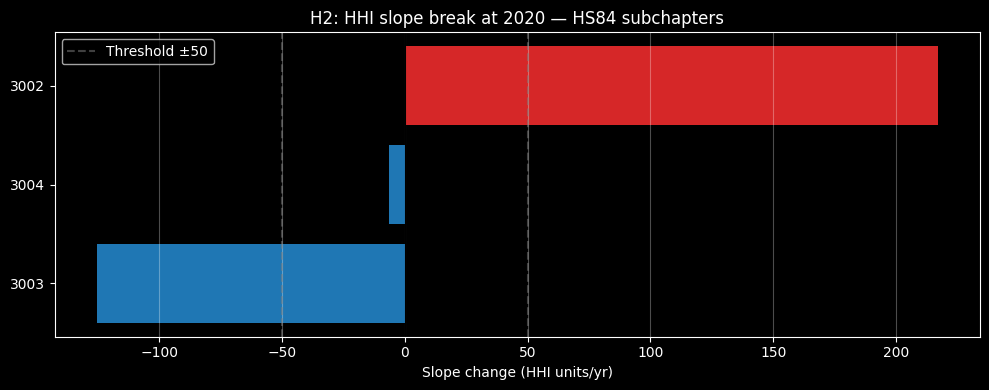

In [18]:
plot_hypothesis_summary(
    h2_2020,
    metric_label="Slope change (HHI units/yr)",
    title="H2: HHI slope break at 2020 — HS84 subchapters",
    threshold=50,
)

## H3: Comparing breakpoints — is the 2022 break stronger than 2020?

In [19]:
h3 = compare_breakpoints(result_f, hhi_f, partner_code="CN")
print(h3)

shape: (3, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ product_co ┆ product_na ┆ share_slop ┆ share_slo ┆ share_str ┆ hhi_slope ┆ hhi_slope ┆ hhi_stron │
│ de         ┆ me         ┆ e_chg_2020 ┆ pe_chg_20 ┆ onger_202 ┆ _chg_2020 ┆ _chg_2022 ┆ ger_2022  │
│ ---        ┆ ---        ┆ ---        ┆ 22        ┆ 2         ┆ ---       ┆ ---       ┆ ---       │
│ i64        ┆ str        ┆ f64        ┆ ---       ┆ ---       ┆ f64       ┆ f64       ┆ bool      │
│            ┆            ┆            ┆ f64       ┆ bool      ┆           ┆           ┆           │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 3002       ┆ Human      ┆ -1.1561    ┆ -1.3953   ┆ true      ┆ 217.09    ┆ 50.11     ┆ false     │
│            ┆ blood;     ┆            ┆           ┆           ┆           ┆           ┆           │
│            ┆ animal     ┆            ┆           ┆           ┆           ┆ 

In [20]:
print("Share: stronger break at 2022 in", h3.filter(pl.col("share_stronger_2022")).height, "of", h3.height, "products")
print("HHI:   stronger break at 2022 in", h3.filter(pl.col("hhi_stronger_2022")).height, "of", h3.height, "products")

Share: stronger break at 2022 in 1 of 3 products
HHI:   stronger break at 2022 in 1 of 3 products


## Segmented trend — example product

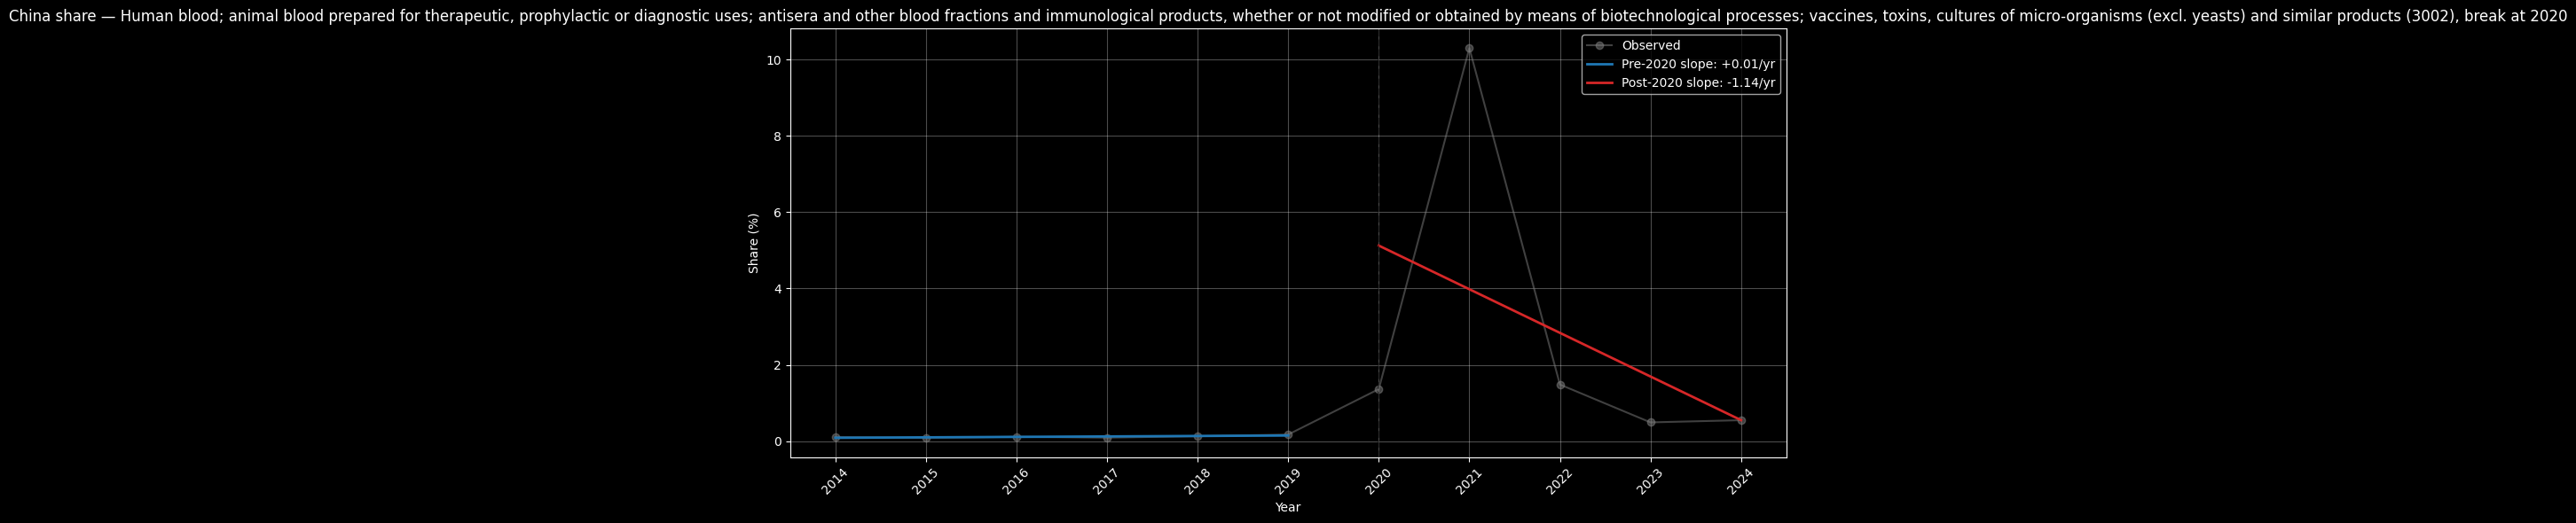

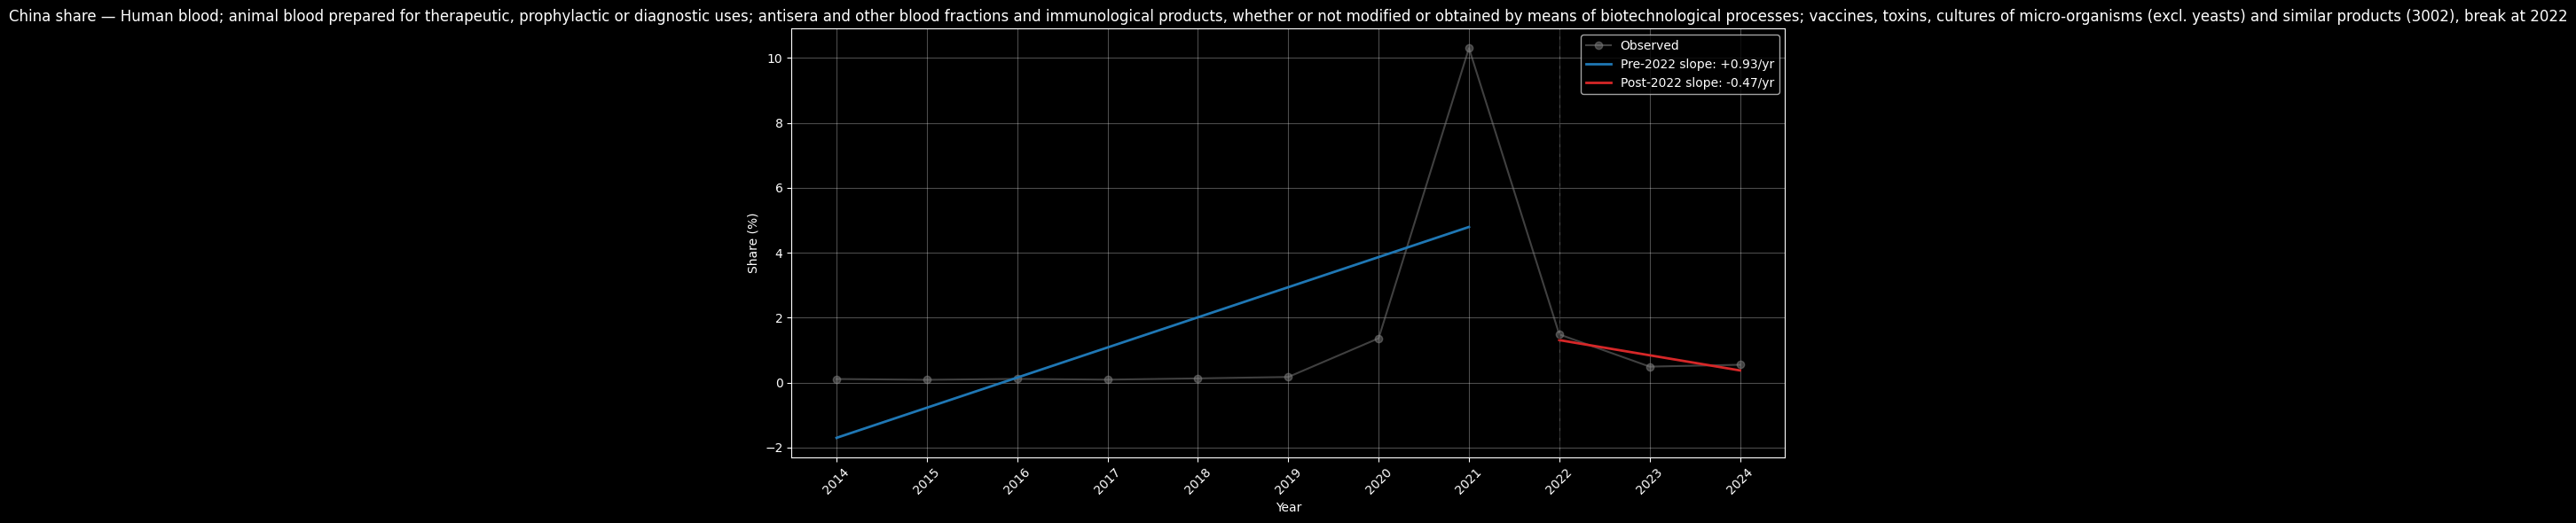

In [22]:
# Segmented trend for China's share in a specific product
example_code = 3002
partner_data = (
    result
    .filter((pl.col("product_code") == example_code) & (pl.col("partner_code") == "CN"))
    .sort("time_period")
)
product_name = partner_data["product_name"][0]

plot_segmented_trend(
    years=partner_data["time_period"].to_list(),
    values=(partner_data["share"] * 100).to_list(),
    cutoff_year=2020,
    title=f"China share — {product_name} ({example_code}), break at 2020",
    ylabel="Share (%)",
)

plot_segmented_trend(
    years=partner_data["time_period"].to_list(),
    values=(partner_data["share"] * 100).to_list(),
    cutoff_year=2022,
    title=f"China share — {product_name} ({example_code}), break at 2022",
    ylabel="Share (%)",
)

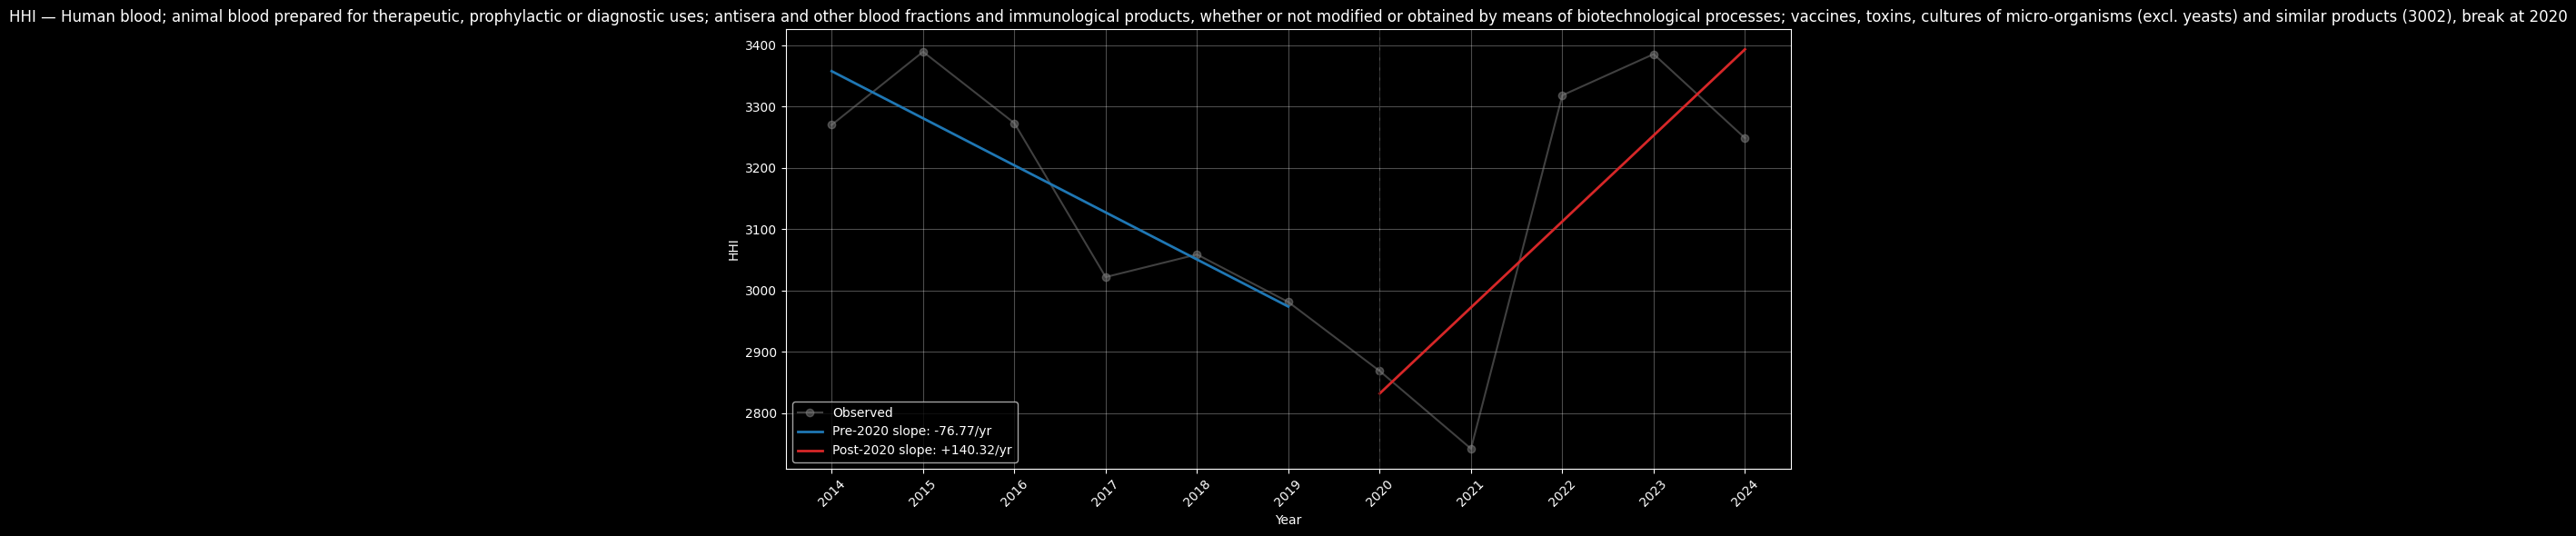

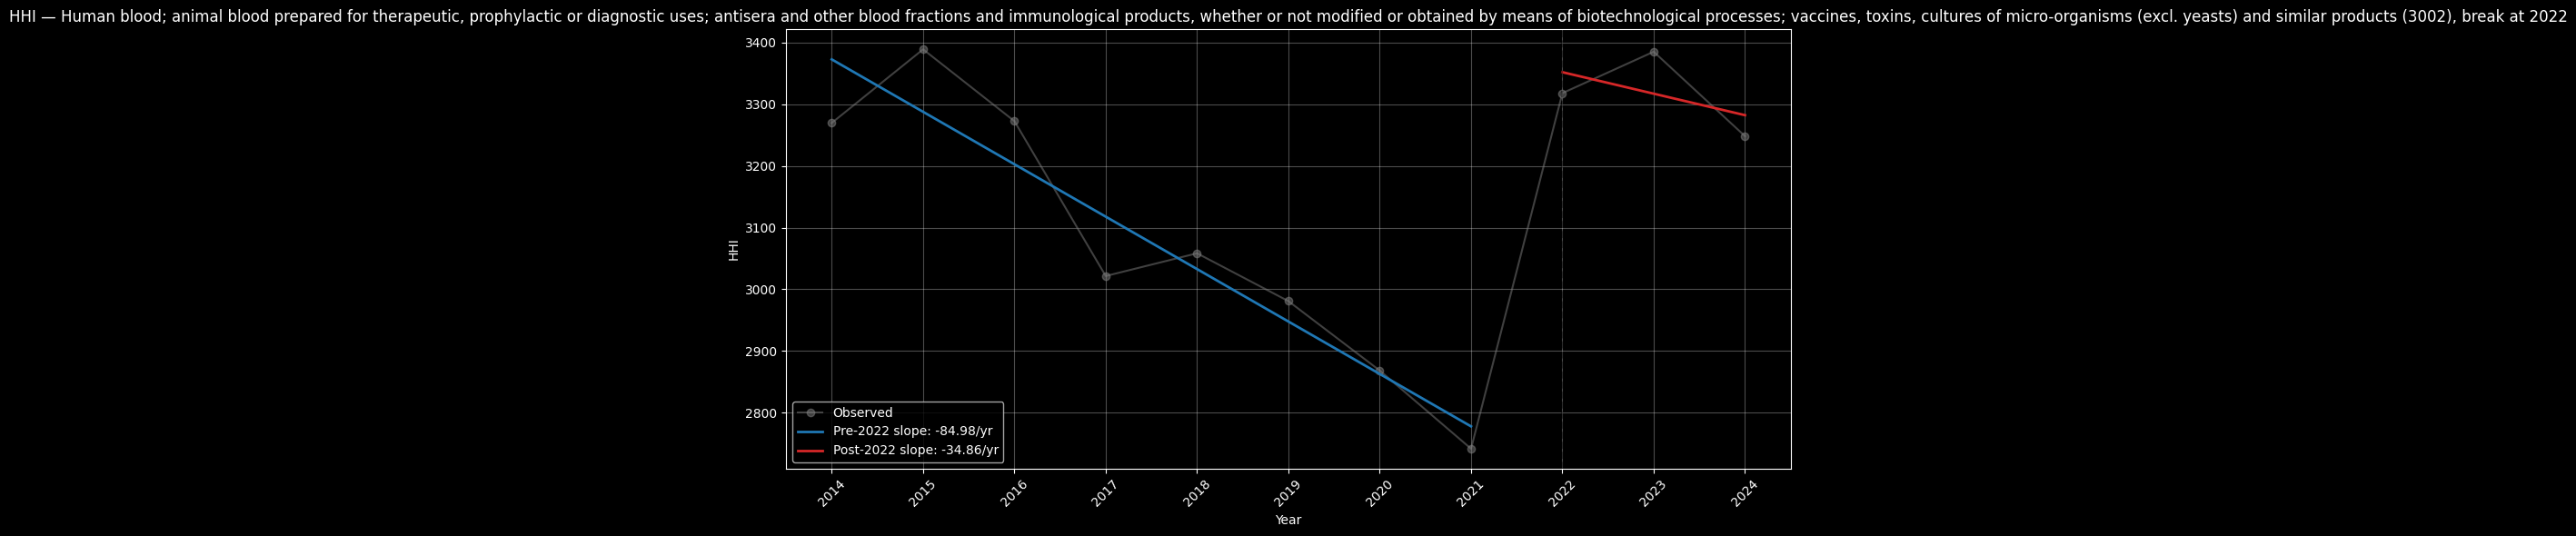

In [23]:
# Segmented trend for HHI of the same product
hhi_data = hhi.filter(pl.col("product_code") == example_code).sort("time_period")

plot_segmented_trend(
    years=hhi_data["time_period"].to_list(),
    values=hhi_data["hhi"].to_list(),
    cutoff_year=2020,
    title=f"HHI — {product_name} ({example_code}), break at 2020",
    ylabel="HHI",
)

plot_segmented_trend(
    years=hhi_data["time_period"].to_list(),
    values=hhi_data["hhi"].to_list(),
    cutoff_year=2022,
    title=f"HHI — {product_name} ({example_code}), break at 2022",
    ylabel="HHI",
)